# TMF AIVA Hackathon User Guide

## Tl'dr





```shell
pip install google-auth

gcloud auth application-default login

python hackathon_client.py
```

## Schemas - Request / Response

> Input Schema
```json
{
    "input": {
      "input": "Describe ODA Canvas?"
    }
}
```

> Output Schema - WIP
```json
{
    "output": {
        "input": "Describe ODA Canvas?",
        "output": "The ODA Canvas is a runtime ..",
        "intermediate_steps": [
            [
                {
                    "type": "constructor",
                    "kwargs": {},
                    "id": [],
                    "lc": 1
                },
                [
                    // pdf search response
                    {
                        "answer": {
                            "steps": [],
                            "relatedQuestions": [],
                            "state": "SUCCEEDED",
                            "references": [],
                            "name": "projects/...",
                            "answerText": "TM Forum and MEF APIs are not directly..",
                            "citations": [{"sources": [{"referenceId": "3"}], "endIndex": "118"},{...}, ...]
                        }
                    },
                    // web search response
                    {
                        "answer": {
                            "state": "SUCCEEDED",
                            "name": "projects/982845833565/...",
                            "relatedQuestions": [],
                            "answerText": ""## ODF: A Comprehensive Framework for Digital ...",
                            "references": [],
                            "steps": [],
                            "citations": [{"sources": [{"referenceId": "3"}], "endIndex": "118"},{...}, ...]
                        }
                    },
                    // image search response
                    {
                        "attributionToken": ""ngHwnQoLCLXL-...",
                        "results": [],
                        "totalSize": 1,
                        "summary": {}
                    }
                ]
            ]
        ]
    }
}
```

> Output schema structure

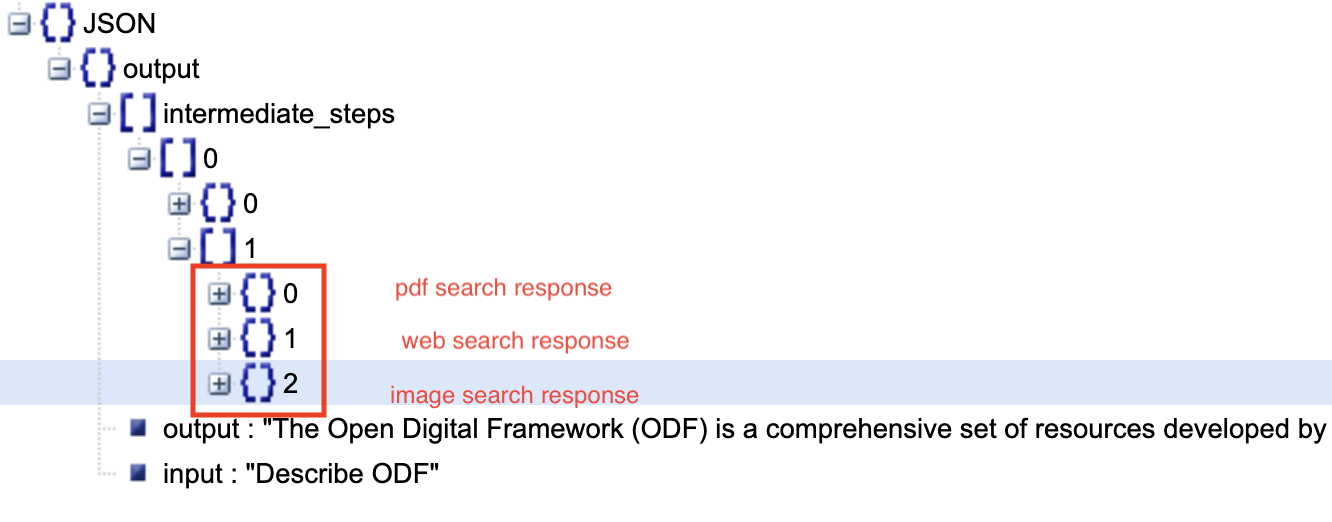

> Output schema json - zooming on only pdf search response

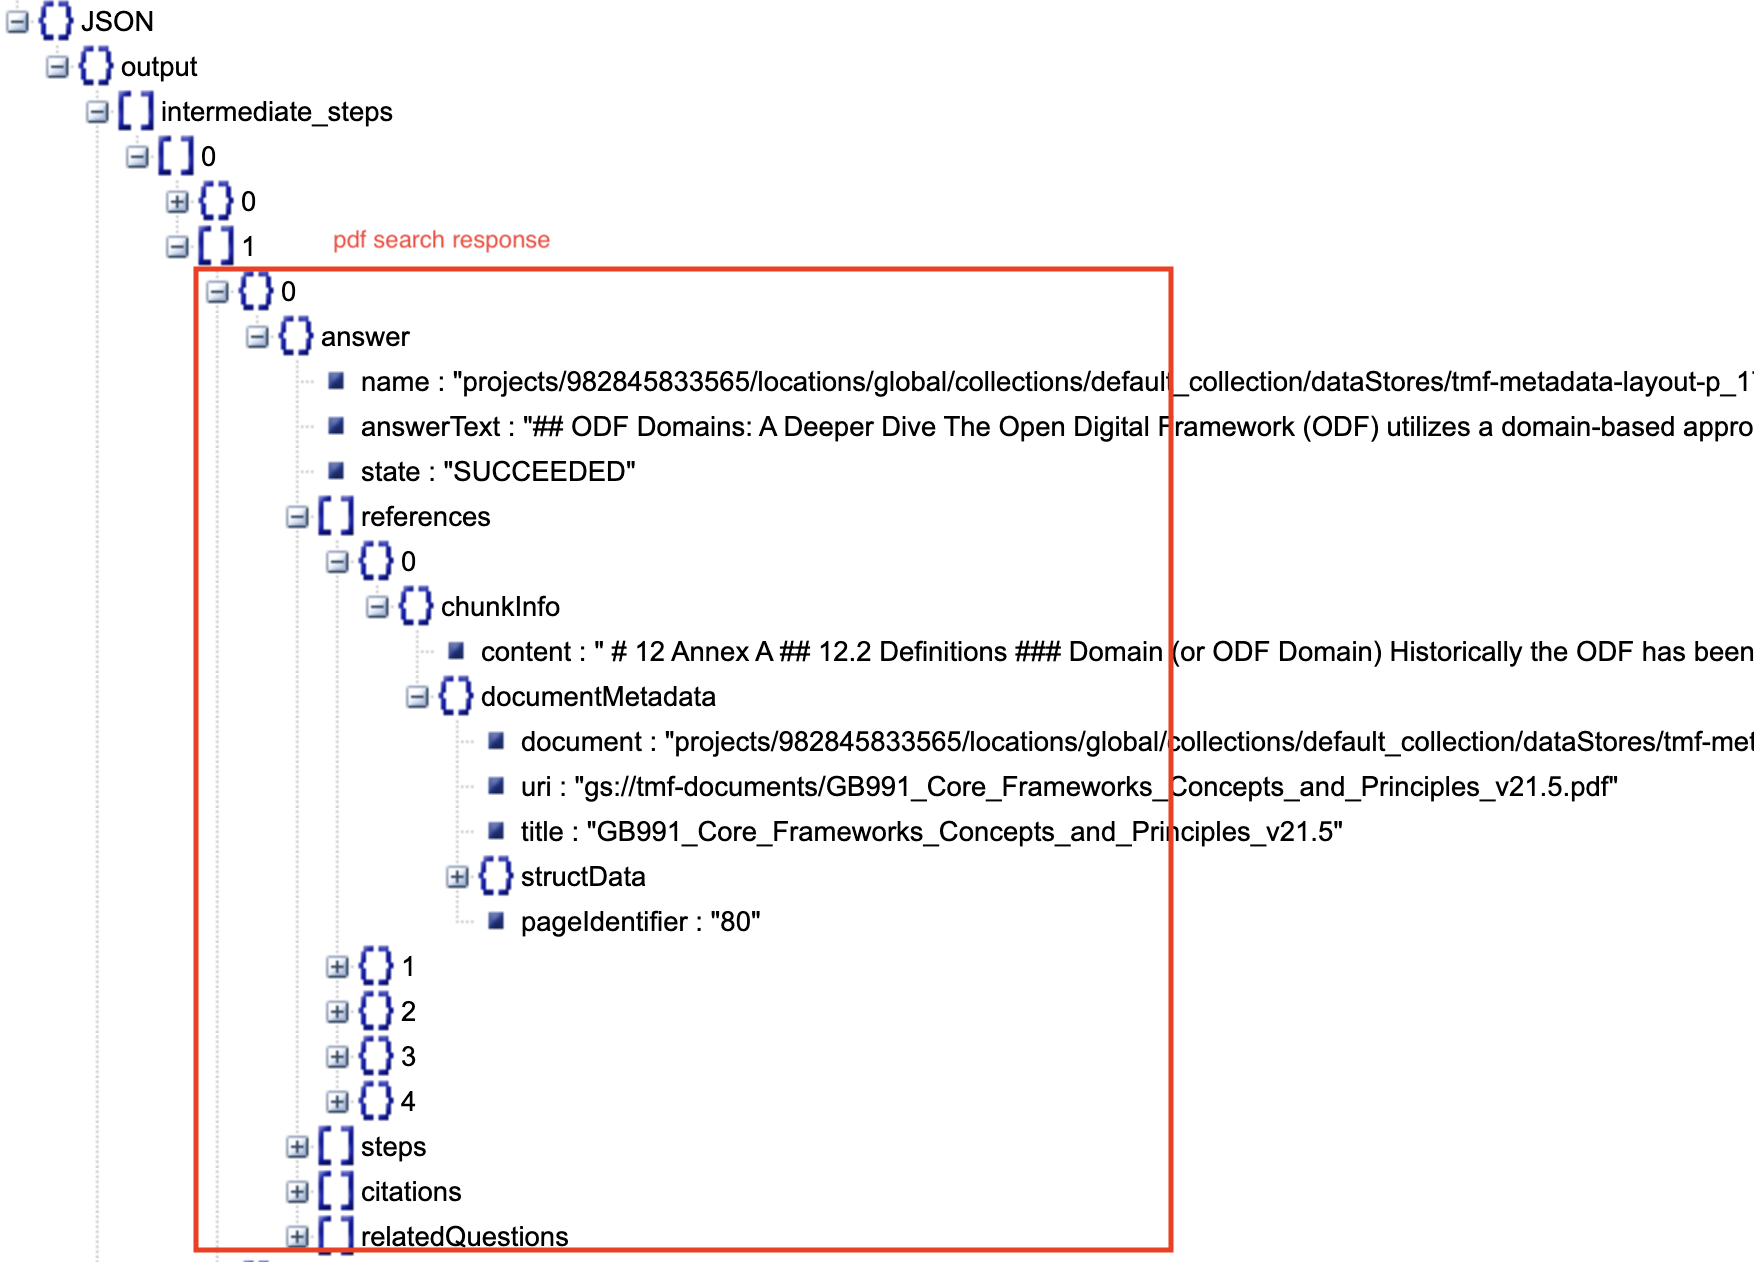

> Output schema json zooming into web search response

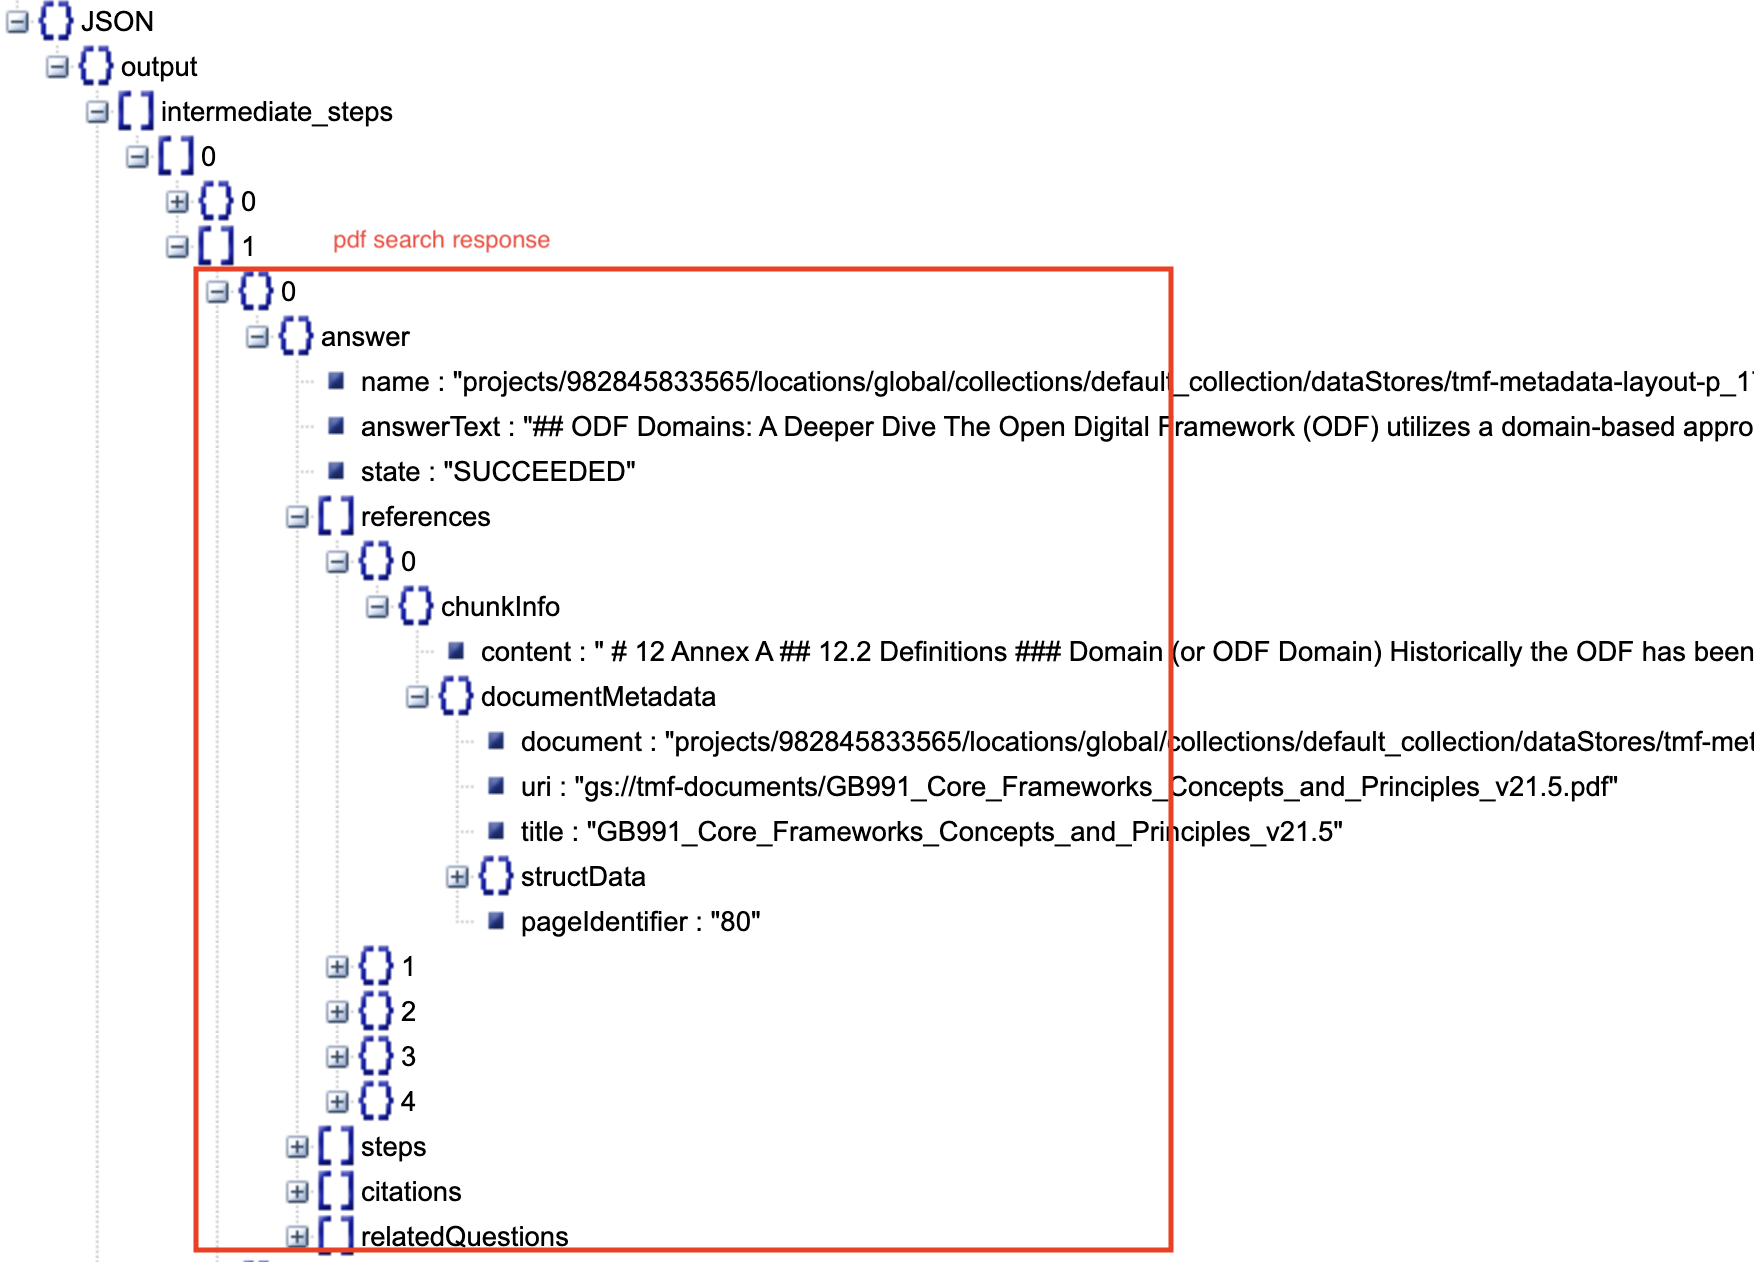

> Output schema json - zooming into image search response

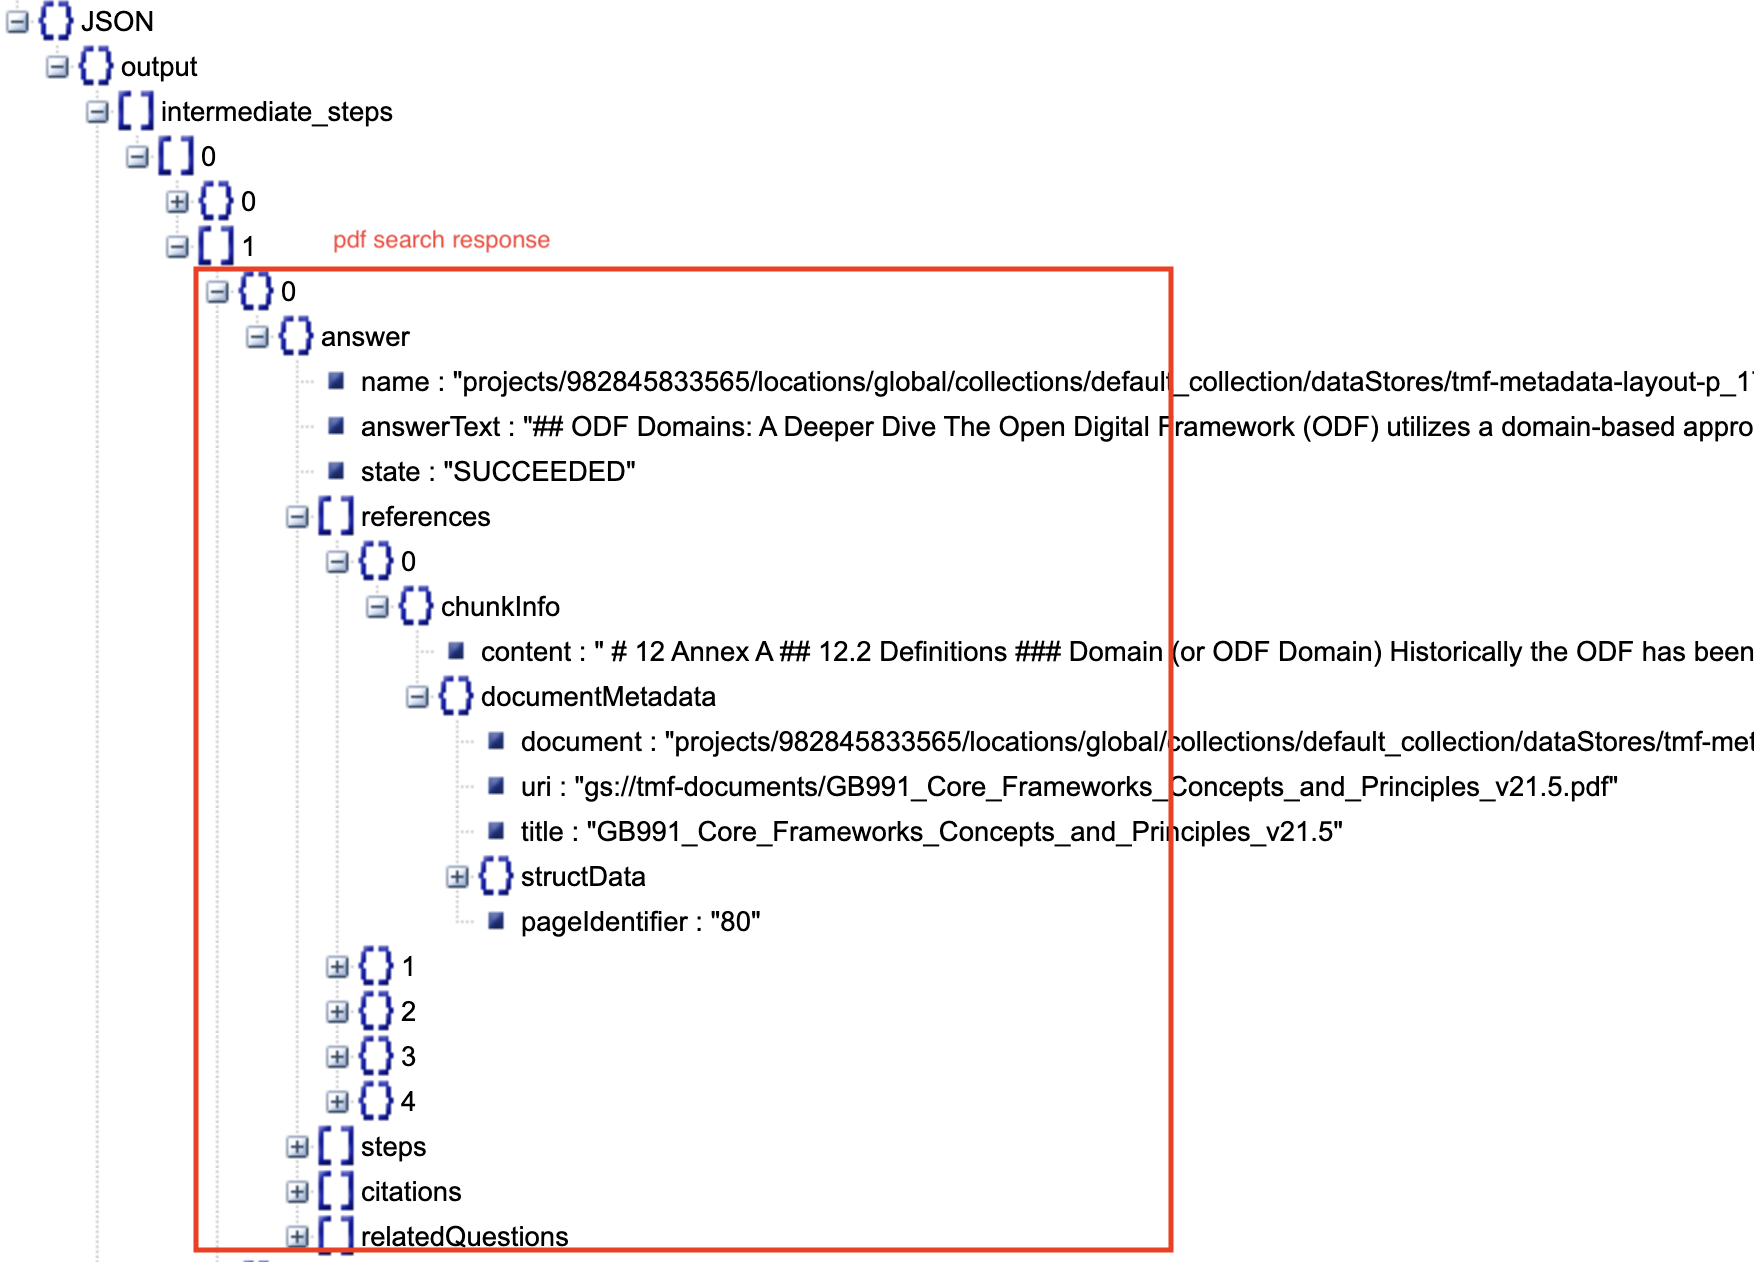

> Output schema json - focusing on code gen response

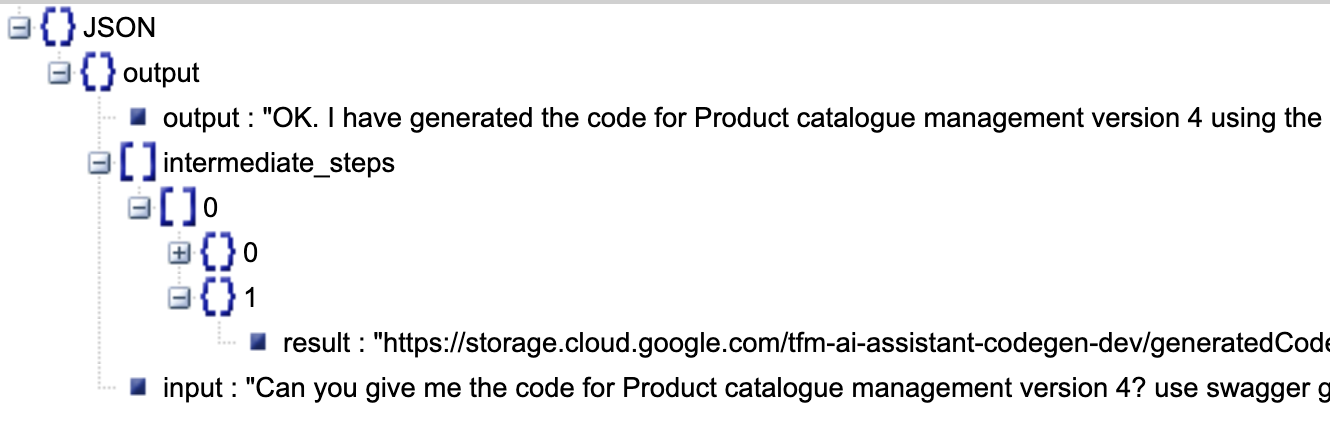

## TMF AIVA - Response parser boiler plate code

In [11]:
# doc_type values - pdf / web
def parse_search_tool_response(response, doc_type="pdf"):
  tool_response = {}
  # check if tool has a answer in the response
  if "answer" in response:
    answer_object = response["answer"]
    # successful retrieval
    if "state" in answer_object and answer_object["state"] == "SUCCEEDED":
      answerText = answer_object["answerText"] if "answerText" in answer_object else ""
      # citations = answer_object["citations"] if "citations" in answer_object else []
      # parse references
      references = []
      references_raw_list = answer_object["references"] if "references" in answer_object else []
      for ref in references_raw_list:
        chunk_info = ref["chunkInfo"] if "chunkInfo" in ref else  ""
        if "" != chunk_info and "documentMetadata" in chunk_info:
          document_metadata = chunk_info["documentMetadata"]
          reference = {}
          title = document_metadata["title"] if "title" in document_metadata else ""
          # TODO change uri from gs:// to http://
          uri = document_metadata["uri"] if "uri" in document_metadata else ""
          reference["title"] = title
          reference["uri"] = uri
          docId = ""
          if doc_type == "pdf":
            if "structData" in document_metadata:
              struct_data = document_metadata["structData"]
              docId = document_metadata["structData"]["DocId"] if "DocId" in document_metadata["structData"] else ""
              reference["docId"] = docId
          references.append(reference)

      related_questions = answer_object["relatedQuestions"] if "relatedQuestions" in answer_object else []
      tool_response = {
        "answerText": answerText,
        "references": references,
        "related_questions": related_questions
      }
    return tool_response


def parse_agent_response(response):
  formated_agent_respone = {}
  if "output" in response:
    agent_output_response = response["output"]
    is_codegen = False
    formated_agent_respone["input"] = agent_output_response["input"]
    formated_agent_respone["output"] = agent_output_response["output"]
    # hacky solution
    if ".zip" in agent_output_response["output"]:
      is_codegen = True
    if "intermediate_steps" in agent_output_response:
      intermediate_steps = agent_output_response["intermediate_steps"]
      if len(intermediate_steps) > 0:
        intermediate_steps = intermediate_steps[0]
        if len(intermediate_steps) == 2:
          tool_responses = intermediate_steps[1]
          if len(tool_responses) == 3:
            pdf_response = tool_responses[0]
            web_response = tool_responses[1]
            image_response = tool_responses[2]
            # parse pdf and web search tool response
            pdf_response_json = parse_search_tool_response(pdf_response, doc_type="pdf")
            web_response_json = parse_search_tool_response(web_response, doc_type="web")
            # parse image search tool response
            image_response_json = {}
            if "summary" in image_response:
              if image_response["summary"] != "":
                image_summary = image_response["summary"]
                image_response_json["summary"] = image_summary

            image_docs = []
            if "results" in image_response:
              if len(image_response["results"]) > 0:
                for image_doc in image_response["results"]:
                  if "document" in image_doc:
                    if "derivedStructData" in image_doc["document"]:
                      title = image_doc["document"]["derivedStructData"]["title"]
                      link = image_doc["document"]["derivedStructData"]["link"]
                      image_metadata = image_doc["document"]["derivedStructData"]["image"]
                      context_link = image_metadata["contextLink"]
                      image = {}
                      image["title"] = title
                      image["link"] = link
                      image["contextLink"] = context_link
                      image_docs.append(image)
                image_response_json["images"] = image_docs

            formated_agent_respone["pdf"] = pdf_response_json
            formated_agent_respone["web"] = web_response_json
            formated_agent_respone["image"] = image_response_json
          elif len(tool_responses) == 1:
            code_gen_response = tool_responses
            if "result" in tool_responses:
              code_gen_response = tool_responses["result"]
              formated_agent_respone["code"] = code_gen_response
          else:
            print("no of tool response: ", len(tool_responses))
  return formated_agent_respone

def build_agent_response_dict(formatted_agent_response):
  agent_response_dict = {}
  if "pdf" in formatted_agent_response:
    agent_response_dict["pdf search summary"] = formatted_agent_response["pdf"]["answerText"]
    # agent_response_dict["pdf citations"] = formatted_agent_response["pdf"]["citations"]
    agent_response_dict["pdf references"] = formatted_agent_response["pdf"]["references"]
  else:
    agent_response_dict["pdf search summary"] = ""
    # agent_response_dict["pdf citations"] = []
    agent_response_dict["pdf references"] = []

  if "web" in formatted_agent_response:
    agent_response_dict["web search summary"] = formatted_agent_response["web"]["answerText"]
    # agent_response_dict["web citations"] = formatted_agent_response["web"]["citations"]
    agent_response_dict["web references"] = formatted_agent_response["web"]["references"]
  else:
    agent_response_dict["web search summary"] = ""
    # agent_response_dict["web citations"] = []
    agent_response_dict["web references"] = []

  if "image" in formatted_agent_response:
    agent_response_dict["images"] = formatted_agent_response["image"]["images"] if "image" in formatted_agent_response and "images" in formatted_agent_response["image"] else []
  else:
    agent_response_dict["images"] = []

  if "code" in formatted_agent_response:
    agent_response_dict["code"] = formatted_agent_response["code"] if "code" in formatted_agent_response else ""
  else:
    agent_response_dict["code"] = ""

  agent_response_dict["agent summary"] = formatted_agent_response["output"] if "output" in formatted_agent_response else ""
  agent_response_dict["input"] = formatted_agent_response["input"] if "input" in formatted_agent_response else ""
  return agent_response_dict


## Curl/Python client code

```python
import os
import google.auth
import json
import requests
from dotenv import load_dotenv, find_dotenv

# agent client code
def call_tmf_aiva_agent(query_str, token, url):
  """Makes a POST request to the specified Reasoning Engine endpoint."""
  # Set the headers and data
  headers = {
    "Authorization": f"Bearer {token}",
    "Content-Type": "application/json; charset=utf-8",
  }

  # Create the JSON payload from the query_str
  json_input = {"input": {"input": f"{query_str}"}}

  # Send the POST request
  r = requests.post(url, headers=headers, data=json.dumps(json_input))
  return r.json()

```

> Sample Agent response

> reasoning_agent_search_response.json - typical response for a search query

> reasoning_agent_code_gen_response.json - typical response for a code gen query



In [12]:
!pip install google-auth

In [13]:
import os
import google.auth
import json
import requests

# agent client code
def call_tmf_aiva_agent(query_str, token, url):
  """Makes a POST request to the specified Reasoning Engine endpoint."""
  # Set the headers and data
  headers = {
    "Authorization": f"Bearer {token}",
    "Content-Type": "application/json; charset=utf-8",
  }

  # Create the JSON payload from the query_str
  json_input = {"input": {"input": f"{query_str}"}}

  # Send the POST request
  r = requests.post(url, headers=headers, data=json.dumps(json_input))
  return r.json()

## Test driver code

In [16]:
url = "https://us-central1-aiplatform.googleapis.com/v1beta1/projects/982845833565/locations/us-central1/reasoningEngines/4637335425680146432:query"

## Generate user default auth token
credentials, _ = google.auth.default()
request = google.auth.transport.requests.Request()
credentials.refresh(request)
token = credentials.token

In [17]:
query = "Describe ODF?"

agent_response_dict = build_agent_response_dict(
    parse_agent_response(call_tmf_aiva_agent(query, token, url)))

print(agent_response_dict)

{'pdf search summary': "## ODF: A Blueprint for Efficient Business Operations\n\nThe TM Forum Open Digital Framework (ODF) provides a comprehensive set of best practices, standards, and core frameworks to guide service providers in achieving efficient and effective business operations.  By adopting a service-oriented design, ODF offers reusable, generic building blocks that can be assembled to create customized solutions while maintaining standardization. This approach fosters differentiation and competition at the service level.\n\nODF's core frameworks include:\n\n* **Business Process Framework (eTOM):** This framework defines the business processes used by service providers, their interrelationships, and their use of information related to markets, products, customers, services, resources, business partners, and enterprise management. eTOM's goal is to establish an industry-standard business process framework and provide common definitions for process elements.\n* **Information Fram